In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'kernel_mean_matching_gradient'
seed = 42

In [2]:
import numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/kernel_mean_matching_gradient'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import cvxopt, autograd
import domain_adapt.domain_adapt.kernels as kernels

* define dimensionality of distributions
* define 2 distributions - train and test.  have their pdf and sampling methods
* set number of train and test samples to generate
* define pairwise within and across train/test sample kernel distances, either directly via a function, or parameterize that function by the feature map
* (below will be a fxn of projection matrix)
* projection matrix
* project train and test raw data to get u's
* use that kernel distance function to populate K and kappa in the optimization problem
* solve the optimization problem to get the B's
* compare B(x) to p_test(u) / p_train(u).  maybe plot scatter plot of B(x) vs that ratio

In [4]:
# define dimensionality of distributions
x_dim = 2
u_dim = 1

In [5]:
# define train distribution
train_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=x_dim))
train_pdf = train_dist.pdf
train_sample = train_dist.rvs

In [6]:
# define test distribution
test_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=x_dim)+1.)
test_pdf = test_dist.pdf
test_sample = test_dist.rvs

In [7]:
# define number of samples to generate
num_train = 10
num_test = 15

In [8]:
# generate the samples
np.random.seed(42)
xs_train = np.array([train_sample() for i in xrange(num_train)])
if len(xs_train.shape) == 1:
    xs_train = xs_train.reshape(len(xs_train),1)
xs_test = np.array([test_sample() for i in xrange(num_test)])
if len(xs_test.shape) == 1:
    xs_test = xs_test.reshape(len(xs_test),1)
print xs_test

[[ 2.46564877  0.7742237 ]
 [ 1.0675282  -0.42474819]
 [ 0.45561728  1.11092259]
 [-0.15099358  1.37569802]
 [ 0.39936131  0.70830625]
 [ 0.39829339  2.85227818]
 [ 0.98650278 -0.05771093]
 [ 1.82254491 -0.22084365]
 [ 1.2088636  -0.95967012]
 [-0.32818605  1.19686124]
 [ 1.73846658  1.17136828]
 [ 0.88435172  0.6988963 ]
 [-0.47852199  0.28015579]
 [ 0.53936123  2.05712223]
 [ 1.34361829 -0.76304016]]


In [9]:
# define kernel function
sigma = 0.1
get_K = functools.partial(kernels.get_gaussian_K, sigma)

In [10]:
# define hyperparameters
B_max = 100
eps = 0.1

In [11]:
# define projection matrix 1
#P1 = kernels.ortho(np.random.normal(size=(x_dim, u_dim)))
P1 = kernels.ortho(np.array([[1.,2.]]).T)
assert P1.shape[0] == x_dim
assert P1.shape[1] <= u_dim

In [12]:
# define projection matrix 2
#delta_P_direction = kernels.ortho(np.random.normal(size=(x_dim, u_dim)))
delta_P_direction = kernels.ortho(np.array([[1,0]]).T)
delta_P_direction = delta_P_direction / np.linalg.norm(delta_P_direction)
delta = 0.0001
P2 = P1 + (delta_P_direction * delta)
assert P2.shape[0] == x_dim
assert P2.shape[1] <= u_dim

In [13]:
# define fxn from projection matrix to B's
the_get_KMM_ws = functools.partial(kernels.get_KMM_ws, xs_train, xs_test, get_K, B_max, eps)

In [14]:
# fxn to plot results
def plot_KMM_results(P, xs_train, xs_test, B):
    
    if verbose:
        
        # calculate true B's
        test_projected_pdf = test_pdf # INCORRECT
        train_projected_pdf = train_pdf
        true_B = test_projected_pdf(train_us) / train_projected_pdf(train_us)
        
        # define plot constants
        s = 2
        max_lim = 10
        
        # plot 
        fig, ax = plt.subplots()
        ax.scatter(train_us, true_B, s=s,color='red',label='true ratio')
        ax.scatter(train_us, B,s=s,color='blue',label='estimated ratio')
        #ax.set_xlim((-max_lim,max_lim/2))
        ax.set_ylim((0,max_lim))
        ax.set_xlabel('u')
        ax.set_ylabel('ratio')
        ax.legend()
        basic.display_fig_inline(fig)
        
        # plot scatterplot
        fig, ax = plt.subplots()
        ax.scatter(true_B,B, s=s)
        ax.set_xlabel('true')
        ax.set_ylabel('predicted')
        ax.set_xlim((0,max_lim))
        ax.set_ylim((0,max_lim))
        basic.display_fig_inline(fig)
        
    return B

In [15]:
# calculate derivative of B's in direction delta_P at P
B_P1 = the_get_KMM_ws(P1)
B_P2 = the_get_KMM_ws(P2)
deriv = (B_P2 - B_P1) / delta
deriv

     pcost       dcost       gap    pres   dres
 0:  1.4688e+02 -3.0369e+03  5e+04  6e-01  3e-14
 1:  3.2594e+00 -1.1996e+03  1e+03  2e-16  3e-12
 2:  3.1999e+00 -2.0612e+01  2e+01  2e-16  1e-13
 3:  2.5557e+00 -5.9450e+00  9e+00  1e-16  3e-14
 4:  9.6831e-01 -7.8799e+00  9e+00  2e-16  3e-14
 5:  7.2325e-01  2.1319e-01  5e-01  3e-16  8e-15
 6:  7.0509e-01  6.9243e-01  1e-02  2e-16  8e-15
 7:  7.0500e-01  7.0486e-01  1e-04  1e-16  3e-14
 8:  7.0500e-01  7.0500e-01  1e-06  2e-16  7e-14
 9:  7.0500e-01  7.0500e-01  1e-08  1e-16  8e-14
Optimal solution found.
[ 1.87534847  1.08250116  1.04344811  0.83394479  0.85726605  0.72138579
  0.3929636   0.7219596   1.06321594  0.4079665 ]
     pcost       dcost       gap    pres   dres
 0:  1.4690e+02 -3.0361e+03  5e+04  6e-01  2e-14
 1:  3.2622e+00 -1.1996e+03  1e+03  2e-16  2e-12
 2:  3.2028e+00 -2.0606e+01  2e+01  2e-16  5e-14
 3:  2.5593e+00 -5.9443e+00  9e+00  2e-16  2e-14
 4:  9.7118e-01 -7.8800e+00  9e+00  2e-16  2e-14
 5:  7.2634e-01  2.164

array([ 1.57352313, -5.94382082, -1.10304408, -1.0455243 , -5.3996621 ,
        3.49918155,  3.05582279,  3.60893293, -1.93025986,  3.68485076])

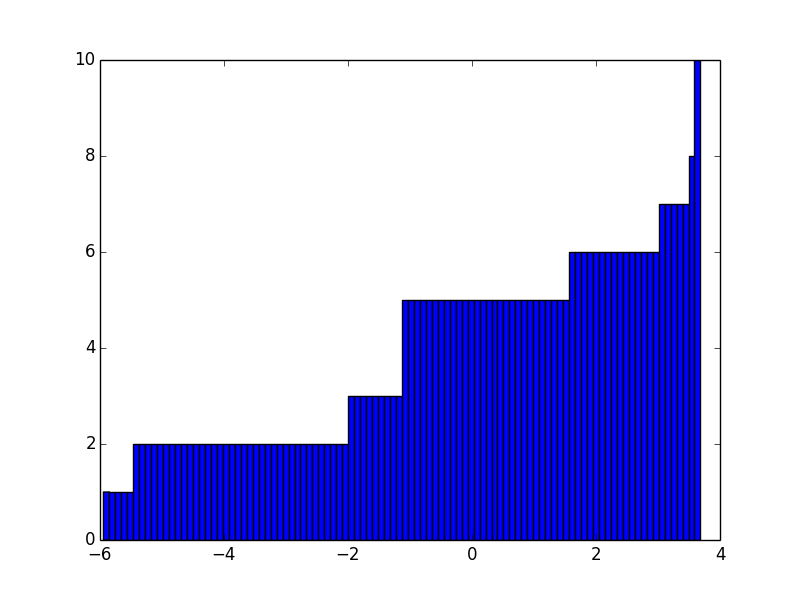

In [16]:
# plot hist of deriv of B's
fig, ax = plt.subplots()
ax.hist(deriv, bins = 100, cumulative=True)
basic.display_fig_inline(fig)

In [17]:
# identify initially tight constraints
print 'smallest_weight', np.min(B_P1)
tight_eps = np.min(B_P1) + .001
tight = (B_P1 < tight_eps) | (B_P1 > B_max - tight_eps)
print 'num tight:', np.sum(tight)

smallest_weight 0.392963599479
num tight: 1


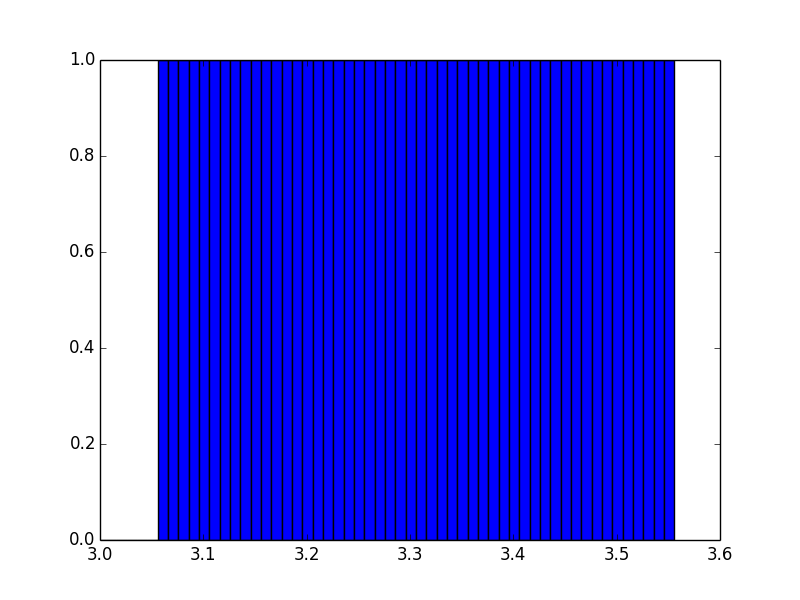

In [18]:
# plot hist of deriv of B's that were initially tight.  should all be 0
fig, ax = plt.subplots()
ax.hist(deriv[tight], bins = 100, cumulative=True)
basic.display_fig_inline(fig)

In [19]:
# general stuff needed to calculate gradient

def f(get_K, B, P):
    
    # create K, kappa, use them to return objective fxn value
    
    import autograd, autograd.numpy as np
    
    us_train = np.dot(xs_train, P)
    us_test = np.dot(xs_test, P)
    K, kappa = kernels.get_KMM_params(us_train, us_test, get_K)
    
    return np.dot(np.dot(B.T, K), B)/2. + np.dot(kappa, B)

the_f = functools.partial(f, get_K)

A, b = kernels.get_KMM_ineq_constraints(num_train, B_max, eps)

In [20]:
# define some solvers
lstsq_solver = lambda A,b: np.linalg.lstsq(A, b)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
solver = lstsq_solver
#solver = cg_solver

In [21]:
# file fxn deriv
ws1 = kernels.get_KMM_ws(xs_train, xs_test, get_K, B_max, eps, P1)
anal_deriv = kernels.get_dx_opt_delta_p(solver, the_f, A, b, ws1, P1, delta_P_direction)
anal_deriv

     pcost       dcost       gap    pres   dres
 0:  1.4688e+02 -3.0369e+03  5e+04  6e-01  3e-14
 1:  3.2594e+00 -1.1996e+03  1e+03  2e-16  3e-12
 2:  3.1999e+00 -2.0612e+01  2e+01  2e-16  1e-13
 3:  2.5557e+00 -5.9450e+00  9e+00  1e-16  3e-14
 4:  9.6831e-01 -7.8799e+00  9e+00  2e-16  3e-14
 5:  7.2325e-01  2.1319e-01  5e-01  3e-16  8e-15
 6:  7.0509e-01  6.9243e-01  1e-02  2e-16  8e-15
 7:  7.0500e-01  7.0486e-01  1e-04  1e-16  3e-14
 8:  7.0500e-01  7.0500e-01  1e-06  2e-16  7e-14
 9:  7.0500e-01  7.0500e-01  1e-08  1e-16  8e-14
Optimal solution found.
[ 1.87534847  1.08250116  1.04344811  0.83394479  0.85726605  0.72138579
  0.3929636   0.7219596   1.06321594  0.4079665 ]
Q [[  1.00000000e+000   3.97741298e-053   2.01012289e-004   4.25998653e-037
    2.09320793e-001   4.69615567e-012   1.34859811e-063   1.19331060e-041
    2.58752451e-002   1.38841344e-068]
 [  3.97741298e-053   1.00000000e+000   1.16597083e-084   3.47308669e-002
    7.10942126e-042   3.49392489e-113   8.61826081e-

array([ 1.57853197, -5.9478822 , -1.09534694, -1.04866549, -5.40050616,
        3.4995515 ,  3.05552588,  3.61049977, -1.93490254,  3.6831942 ,
       -3.74548334])

In [22]:
assert False

AssertionError: 

In [ ]:

df_dB = autograd.grad(the_f) # ans dim: |B|
d_dP_df_dB = autograd.jacobian(lambda P,B: df_dB(B,P)) # ans dim: |B| x |P|

def tight_constraints(B, num_train, B_max, eps):
    G,h = kernels.get_KMM_ineq_constraints(num_train, B_max, eps)
    LHS = np.dot(G,B)
    assert (LHS < h).all()
    tight_eps = 0.0001
    tight = (h - LHS) < tight_eps
    return G[tight], h[tight]

In [ ]:
# test f at B_P1 to see if cost matches that from solver
the_f(B_P1, P1)

In [ ]:
# compute quantities needed to solve equation that gives gradient
A_tight, b_tight = tight_constraints(B_P2, num_train, B_max, eps)
num_tight = A_tight.shape[0]
print 'num_tight:', num_tight
print df_dB(B_P1, P1)
print d_dP_df_dB(P1, B_P1)
d_top = -np.sum(d_dP_df_dB(P1, B_P1) * (delta_P_direction[np.newaxis,:,:]), axis=(1,2))
print 'd_top',d_top
d_bottom = np.zeros(num_tight)
d = np.hstack((d_top,d_bottom))
Q_P1 = get_K(np.dot(xs_train, P1), np.dot(xs_train, P1))
print 'Q', Q_P1
C = np.vstack((np.hstack((Q_P1,-A_tight.T)), np.hstack((A_tight,np.zeros((num_tight,num_tight))))))
C.shape
anal_deriv = np.dot(np.linalg.inv(C),d)
print 'solver error', np.linalg.norm(d - np.dot(C,anal_deriv))
anal_deriv

In [23]:
print deriv.shape, anal_deriv.shape
#print deriv
#print anal_deriv
for x in zip(deriv,anal_deriv):
    print x

(10,) (11,)
(1.5735231349078838, 1.5785319686345372)
(-5.9438208154194427, -5.9478822027924112)
(-1.1030440799397745, -1.095346938043043)
(-1.0455243034401818, -1.0486654892396114)
(-5.3996620957441621, -5.4005061577745668)
(3.4991815468887744, 3.4995515042225351)
(3.0558227859350806, 3.0555258830433178)
(3.6089329280541982, 3.6104997673817598)
(-1.9302598618131661, -1.93490253921543)
(3.6848507603276515, 3.6831942037829268)
